<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day3/unet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a U-net

The [U-net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) is a very popular model architecture for segmentation in bioimage analysis.
Here, we will train a 2D U-net for nuclei segmentation, using data from the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

In [48]:
from skimage.io import imread, imsave
from skimage.morphology import remove_small_holes

In [62]:
import uuid

In [82]:
str(uuid.uuid4())

'05359939-a4a2-4c60-b826-27a7fe08d432'

In [87]:
def convert_and_save(image, mask, output_dir):
    u_id = str(uuid.uuid4())
    if (not os.path.exists(os.path.join(output_dir, u_id))):
        os.mkdir(os.path.join(output_dir, u_id))
        os.mkdir(os.path.join(output_dir, u_id, 'masks'))
        os.mkdir(os.path.join(output_dir, u_id, 'images'))
                 
    for k in range(1, mask.max()+1):
        mask_u_id = str(uuid.uuid4())
        single_mask = (mask==k)
        mask_cleaned = remove_small_holes(single_mask)
        imsave(os.path.join(output_dir, u_id, 'masks', mask_u_id + '.tif'), mask_cleaned)
    
    imsave(os.path.join(output_dir, u_id, 'images', u_id + '.tif'), image)

In [72]:
train_indices = ['34', '0', '36', '19', '10', '17', '18', '8', '25', '7', '37', '23', '29', '50', '42', '43', '32', '49', '33', '15', '31', '24', '9', '28', '5', '2', '39', '16', '22', '48', '44', '14', '6', '54', '45', '51', '41', '35']
val_indices = ['53', '21', '20', '13', '26', '46', '12', '52', '47', '27', '55', '1', '3', '4', '40', '38', '30']

In [74]:
input_dir = '../../../dl-course-2022/07_esc_3d_colonies/'

In [75]:
output_dir = '../../../tmp/tif_data/train/'

In [88]:
for i in train_indices:
    image = imread(os.path.join(input_dir, 'images', 'esc_siRDNA_' + i + '.tif'))
    mask = imread(os.path.join(input_dir, 'masks', 'esc_siRDNA_' + i + '.tif'))
    convert_and_save(image, mask, output_dir)

/tmp/ipykernel_22385/2674854036.py:12: UserWarning: ../../../tmp/tif_data/train/ad7af566-c87c-46df-80bb-c4de904d6534/masks/ea66c66e-f35c-457e-afec-ae4cb75258ec.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(os.path.join(output_dir, u_id, 'masks', mask_u_id + '.tif'), mask_cleaned)
/tmp/ipykernel_22385/2674854036.py:12: UserWarning: ../../../tmp/tif_data/train/ad7af566-c87c-46df-80bb-c4de904d6534/masks/ea66c66e-f35c-457e-afec-ae4cb75258ec.tif is a low contrast image
  imsave(os.path.join(output_dir, u_id, 'masks', mask_u_id + '.tif'), mask_cleaned)
/tmp/ipykernel_22385/2674854036.py:12: UserWarning: ../../../tmp/tif_data/train/ad7af566-c87c-46df-80bb-c4de904d6534/masks/ed80a40d-fdf3-4ef2-bf6b-dd81f7aa47cf.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(os.path.join(output_dir, u_id, 'masks', mask_u_id + '.t

In [90]:
output_dir = '../../../tmp/tif_data/val/'

In [91]:
for i in val_indices:
    image = imread(os.path.join(input_dir, 'images', 'esc_siRDNA_' + i + '.tif'))
    mask = imread(os.path.join(input_dir, 'masks', 'esc_siRDNA_' + i + '.tif'))
    convert_and_save(image, mask, output_dir)

/tmp/ipykernel_22385/2674854036.py:12: UserWarning: ../../../tmp/tif_data/val/11a5c5ad-f5a1-417b-b260-eb095de19632/masks/5fbf76eb-d2f8-4232-a7d0-dcf3d336bffb.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(os.path.join(output_dir, u_id, 'masks', mask_u_id + '.tif'), mask_cleaned)
/tmp/ipykernel_22385/2674854036.py:12: UserWarning: ../../../tmp/tif_data/val/11a5c5ad-f5a1-417b-b260-eb095de19632/masks/5fbf76eb-d2f8-4232-a7d0-dcf3d336bffb.tif is a low contrast image
  imsave(os.path.join(output_dir, u_id, 'masks', mask_u_id + '.tif'), mask_cleaned)
/tmp/ipykernel_22385/2674854036.py:12: UserWarning: ../../../tmp/tif_data/val/11a5c5ad-f5a1-417b-b260-eb095de19632/masks/97350816-9fa0-4739-866e-af82a4a55c2a.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(os.path.join(output_dir, u_id, 'masks', mask_u_id + '.tif'), 

## The libraries

In [92]:
%matplotlib inline
%load_ext tensorboard
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import binary_erosion
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Split tiffs into training and validation data sets. Indices of train / val are same as used in trraining of 3dunet (Wolny et al.).

## Data loading and preprocessing

We first download amd explore the data.

Now make sure that the data was downloaded and extracted correctly. If everything went fine, you should have folders `nuclei_train_data` and `nuclei_val_data` in your working directory:

In [93]:
def show_one_image(image_path):
  image = imageio.imread(image_path)
  plt.imshow(image)

The first step to training a network in pytorch is to write a dataset - a class that will fetch the training samples. You can find a dataset class for the nucleus data below. 
You can find more information about datasets in pytorch [here](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) and [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class).

The main idea: any Dataset class should have two methods: `len` that returns the dataset length (the number of elements) and `getitem` that, given an index, returns input (image) and target (ground truth).

Please have a look at the dataset implementation:

In [99]:
# any PyTorch dataset class should inherit the initial torch.utils.data.Dataset
class NucleiDataset(Dataset):
    """ A PyTorch dataset to load cell images and nuclei masks """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # the directory with all the training samples
        self.samples = os.listdir(root_dir) # list the samples
        self.transform = transform    # transformations to apply to both inputs and targets
        #  transformations to apply just to inputs
        self.inp_transforms = transforms.Compose([transforms.Grayscale(), # some of the images are RGB
                                                  transforms.ToTensor(),
                                                  transforms.Normalize([0.5], [0.5])])
        # transformations to apply just to targets
        self.mask_transforms = transforms.ToTensor()

    # get the total number of samples
    def __len__(self):
        return len(self.samples)

    # fetch the training sample given its index
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.samples[idx],
                                'images', self.samples[idx]+'.tif')
        # we'll be using Pillow library for reading files
        # since many torchvision transforms operate on PIL images 
        image = Image.open(img_path)
        image = self.inp_transforms(image)
        masks_dir = os.path.join(self.root_dir, self.samples[idx], 'masks')
        # masks directory has multiple images - one mask per nucleus
        masks_list = os.listdir(masks_dir)
        # create an empty array
        mask = torch.zeros_like(image)
        # iterate through the images to sum them up to one mask
        for mask_name in masks_list:
            one_nuclei_mask = Image.open(os.path.join(masks_dir, mask_name))
            # erode the image by one pixel
            # TASK: guess why is this done?
            one_nuclei_mask = binary_erosion(one_nuclei_mask)
            one_nuclei_mask = self.mask_transforms(one_nuclei_mask)
            # add this nucleus to the mask
            mask += one_nuclei_mask
        if self.transform is not None:
            image, mask = self.transform([image, mask])
        return image, mask

Now let's load the dataset and visualize it with a simple function:

In [100]:
TRAIN_DATA_PATH = '../../../tmp/tif_data/train/'
train_data = NucleiDataset(TRAIN_DATA_PATH)

In [105]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))    # take a random sample
    img, mask = dataset[idx]                    # get the image and the nuclei masks
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img[0])                     # show the image
    axarr[1].imshow(mask[0])                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print('Image size is %s' % {img[0].shape})
    plt.show()

In [111]:
train_data.__getitem__(2)

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

Image size is {torch.Size([1024, 1024])}


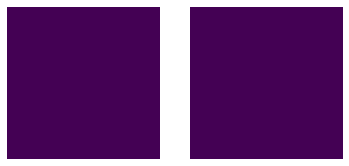

In [106]:
show_random_dataset_image(train_data)

If you visualized many images, you will see that some of them are fairly large. What happens if we load them into memory and feed them to the mode? We might run out of memory. 
Consequently, when training networks on images or volumes one has to be careful about the input sizes. Also, for training in batches, i.e. feeding multiple images to the network at once, all images in the batch have to be of the same size. Hence all images need to be cropped or rescaled to the same size.

For this exercise we implement a class that will apply a transformation `random crop`. Notice that we apply it to images and masks simultaneously to make sure they correspond despite the randomness.

In case anybody is wondering why we have to bother to write a whole class for it instead of simply cropping the images directly in the dataset: we want to keep the code modular. We want to write one dataset object, and then we can try all the possible transforms with this one dataset. Similarly, we want to write one `RandomCrop` transform object, and then we can reuse it for any other image datasets we night have in the future.

In [112]:
class RandomCrop(object):
    """Crop randomly the input image and the output mask"""
    def __init__(self, crop_size):
        # check if the crop size is of a valid type
        assert isinstance(crop_size, (int, tuple, list))
        if isinstance(crop_size, int):
            # if the crop size is an integer, we use the same for both dimensions
            self.output_size = (crop_size, crop_size)
        else:
            assert len(crop_size) == 2
            self.crop_size = crop_size

    # this function makes our class callable 
    def __call__(self, sample):
        # we need to crop both input and mask at the same time
        assert len(sample) == 2
        image, mask = sample
        # the first dimension is channels, then width, then height
        w, h = image.shape[1:]
        new_w, new_h = self.output_size
        # choose a random place to crop
        top = np.random.randint(0, h - new_h) if h - new_h > 0 else 0
        left = np.random.randint(0, w - new_w) if w - new_w > 0 else 0
        # crop and return
        image = image[:, left: left + new_w, top: top + new_h]
        mask = mask[:, left: left + new_w, top: top + new_h]
        return image, mask

PS: PyTorch already has quite a bunch of all possible data transforms, so if you need one, check [here](https://pytorch.org/docs/stable/torchvision/transforms.html). The biggest problem with them is that they are clearly separated into transforms applied to PIL images (remember, we initially load the images as PIL.Image?) and torch.tensors (remember, we converted the images into tensors by calling transforms.ToTensor()?). This can be quite annoying if for some reason you might need to transorm your images to tensors before applying any other transforms or you don't want to use PIL library at all.

In [113]:
train_data = NucleiDataset(TRAIN_DATA_PATH, RandomCrop(256))
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)

Image size is {torch.Size([256, 256])}


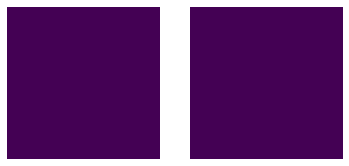

In [114]:
show_random_dataset_image(train_data)

And the same for the validation data:

In [16]:
VAL_DATA_PATH = 'nuclei_val_data'
val_data = NucleiDataset(VAL_DATA_PATH, RandomCrop(256))
val_loader = DataLoader(val_data, batch_size=5)

Image size is {torch.Size([256, 256])}


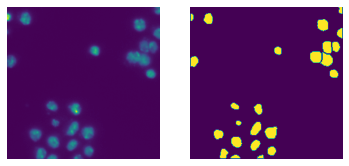

In [17]:
show_random_dataset_image(val_data)

## The model: U-net

Now we need to define the architecture of the model to use. This time we will use a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) that has proven to steadily outperform the other architectures in segmenting biological and medical images.

The image of the model precisely describes all the building blocks you need to use to create it. All of them can be found in the list of PyTorch layers (modules) [here](https://pytorch.org/docs/stable/nn.html#convolution-layers).

The U-net has an encoder-decoder structure:
In the encoder pass, the input image is successively downsampled via max-pooling. In the decoder pass it is upsampled again via transposed convolutions.
In adddition, it has skip connections, that bridge the output from an encoder to the corresponding decoder.

In [18]:
class UNet(nn.Module):
    """ UNet implementation
    Arguments:
      in_channels: number of input channels
      out_channels: number of output channels
      final_activation: activation applied to the network output
    """
    
    # _conv_block and _upsampler are just helper functions to
    # construct the model.
    # encapsulating them like so also makes it easy to re-use
    # the model implementation with different architecture elements
    
    # Convolutional block for single layer of the decoder / encoder
    # we apply to 2d convolutions with relu activation
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU(),
                             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU())       


    # upsampling via transposed 2d convolutions
    def _upsampler(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size=2, stride=2)
    
    def __init__(self, in_channels=1, out_channels=1, 
                 final_activation=None):
        super().__init__()
        
        # the depth (= number of encoder / decoder levels) is
        # hard-coded to 4
        self.depth = 4

        # the final activation must either be None or a Module
        if final_activation is not None:
            assert isinstance(final_activation, nn.Module), "Activation must be torch module"
        
        # all lists of conv layers (or other nn.Modules with parameters) must be wraped
        # itnto a nn.ModuleList
        
        # modules of the encoder path
        self.encoder = nn.ModuleList([self._conv_block(in_channels, 16),
                                      self._conv_block(16, 32),
                                      self._conv_block(32, 64),
                                      self._conv_block(64, 128)])
        # the base convolution block
        self.base = self._conv_block(128, 256)
        # modules of the decoder path
        self.decoder = nn.ModuleList([self._conv_block(256, 128),
                                      self._conv_block(128, 64),
                                      self._conv_block(64, 32),
                                      self._conv_block(32, 16)])
        
        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool2d(2) for _ in range(self.depth)])
        # the upsampling layers
        self.upsamplers = nn.ModuleList([self._upsampler(256, 128),
                                         self._upsampler(128, 64),
                                         self._upsampler(64, 32),
                                         self._upsampler(32, 16)])
        # output conv and activation
        # the output conv is not followed by a non-linearity, because we apply
        # activation afterwards
        self.out_conv = nn.Conv2d(16, out_channels, 1)
        self.activation = final_activation
    
    def forward(self, input):
        x = input
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)

        # apply base
        x = self.base(x)
        
        # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            x = self.upsamplers[level](x)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))
        
        # apply output conv and activation (if given)
        x = self.out_conv(x)
        if self.activation is not None:
            x = self.activation(x)
        return x

## Loss and distance metrics

Next, we need to define the loss function - a metric that will tell us how close we are to the desired output. This metric should be differentiable, since it needs to be backpropagated. The are [multiple losses](https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html) we could use for the segmentation task.

Take a moment to think which one is better to use for our exercise. If you are not sure, don't forget that you can always google! Before you start implementing the loss yourself, take a look at the [losses](https://pytorch.org/docs/stable/nn.html#loss-functions) already implemented in PyTorch. You can also look for implementations on GitHub.

__TASK__: implement your loss (or take one from pytorch):

In [31]:
loss_function = nn.MSELoss()


We will use the [Dice Coefficeint](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate the network predictions.
We can use it for validation if we interpret set $a$ as predictions and $b$ as labels. It is often used to evaluate segmentations with sparse foreground, because the denominator normalizes by the number of foreground pixels.
The Dice Coefficient is closely related to Jaccard Index / Intersection over Union.

In [20]:
# sorensen dice coefficient implemented in torch
# the coefficient takes values in [0, 1], where 0 is
# the worst score, 1 is the best score
class DiceCoefficient(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        
    # the dice coefficient of two sets represented as vectors a, b ca be 
    # computed as (2 *|a b| / (a^2 + b^2))
    def forward(self, prediction, target):
        intersection = (prediction * target).sum()
        denominator = (prediction * prediction).sum() + (target * target).sum()
        return (2 * intersection / denominator.clamp(min=self.eps))

## Training

Let's start with writing training and validation functions. __TASK__: fix in all the TODOs to make the function run. You can use the function from the classification exercises as a template.

In [54]:
loss_function

MSELoss()

In [93]:
# apply training for one epoch
def train(model, loader, optimizer, loss_function, epoch, device,
          log_interval=100, log_image_interval=20, tb_logger=None):

    # set the model to train mode
    model.train()
    
    # iterate over the batches of this epoch
    for batch_id, (x, y) in enumerate(loader):
        # move input and target to the active device (either cpu or gpu)
        x, y = x.to(device), y.to(device)
        
        # zero the gradients for this iteration
        optimizer.zero_grad()
        
        # apply model, calculate loss and run backwards pass
        prediction = model(x)
        loss = loss_function(prediction, y[:, 0])
        loss.backward()
        optimizer.step()
        
        print(batch_id)
        print(log_interval)
        
        # log to console
        if batch_id % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_id * len(x),
                  len(loader.dataset),
                  100. * batch_id / len(loader), loss.item()))

       # log to tensorboard
        if tb_logger is not None:
            step = epoch * len(loader) + batch_id
            tb_logger.add_scalar(tag='train_loss', scalar_value=loss.item(), global_step=step)
            # check if we log images in this iteration
            if step % log_image_interval == 0:
                tb_logger.add_images(tag='input', img_tensor=x.to('cpu'), global_step=step)
                tb_logger.add_images(tag='target', img_tensor=y.to('cpu'), global_step=step)
                tb_logger.add_images(tag='prediction', img_tensor=prediction.to('cpu').detach(), global_step=step)

In [103]:
# run validation after training epoch
def validate(model, loader, loss_function, metric, step=None, tb_logger=None):
    # set model to eval mode
    model.eval()
    # running loss and metric values
    val_loss = 0
    val_metric = 0
    
    mean_loss = 0
    predictions = []
    labels = []
    
    # disable gradients during validation
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)

            # update the loss
            # the loss function expects a 1d tensor, so we get rid of the second
            # singleton dimensions that is added by the loader when stacking across the batch function
            mean_loss += loss_function(prediction, y[:, 0]).item()

            # compute the most likely class predictions
            # note that 'max' returns a tuple with the
            # index of the maximun value (which correponds to the predicted class)
            # as second entry
            prediction = prediction.max(1, keepdim=True)[1]

            # store the predictions and labels
            predictions.append(prediction[:, 0].to('cpu').numpy())
            labels.append(y[:, 0].to('cpu').numpy())

        
        # iterate over validation loader and update loss and metric values
        # for x, y in loader:
        #    x, y = x.to(device), y.to(device)
        #    TODO: YOUR CODE HERE
    
    # normalize loss and metric
    val_loss /= len(loader)
    val_metric /= len(loader)
    
    if tb_logger is not None:
        assert step is not None, "Need to know the current step to log validation results"
        tb_logger.add_scalar(tag='val_loss', scalar_value=val_loss, global_step=step)
        tb_logger.add_scalar(tag='val_metric', scalar_value=val_metric, global_step=step)
        # we always log the last validation images
        tb_logger.add_images(tag='val_input', img_tensor=x.to('cpu'), global_step=step)
        tb_logger.add_images(tag='val_target', img_tensor=y.to('cpu'), global_step=step)
        tb_logger.add_images(tag='val_prediction', img_tensor=prediction.to('cpu'), global_step=step)
        
    print('\nValidate: Average loss: {:.4f}, Average Metric: {:.4f}\n'.format(val_loss, val_metric))


This time we will use GPU to train faster. Please make sure that your Notebook is running on GPU. 

In [95]:
# check if we have  a gpu
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available")
    device = torch.device("cpu")

GPU is available


In [96]:
# start a tensorboard writer
logger = SummaryWriter('runs/Unet')
%tensorboard --logdir runs

Reusing TensorBoard on port 6010 (pid 51450), started 6:54:20 ago. (Use '!kill 51450' to kill it.)

In [97]:
from torch.optim import Adam

In [98]:
loss_function.to(device)

MSELoss()

In [99]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [100]:
# build a default unet with sigmoid activation
# to normalize predictions to [0, 1]
net = UNet(1, 1, final_activation=nn.Sigmoid())
# move the model to GPU
net = net.to(device)

# use adam optimizer
optimizer = Adam(net.parameters(), lr=1.e-3)

# build the dice coefficient metric
metric = DiceCoefficient()


In [101]:
train

<function __main__.train(model, loader, optimizer, loss_function, epoch, device, log_interval=100, log_image_interval=20, tb_logger=None)>

In [104]:
# train for 25 epochs
# during the training you can inspect the 
# predictions in the tensorboard
n_epochs = 25
for epoch in range(n_epochs):
    # train
    train(net, train_loader, optimizer, loss_function, epoch, device, tb_logger=logger)

    step = (epoch+1) * len(train_loader.dataset)
    # validate
    validate(net, val_loader, loss_function,
             device, step,
             tb_logger=logger)

0
100
Train Epoch: 0 [0/536 (0%)]	Loss: 0.119897
1
100
2
100
3
100
4
100
5
100
6
100
7
100
8
100
9
100
10
100
11
100
12
100
13
100
14
100
15
100
16
100
17
100
18
100
19
100
20
100
21
100
22
100
23
100
24
100
25
100
26
100
27
100
28
100
29
100
30
100
31
100
32
100
33
100
34
100
35
100
36
100
37
100
38
100
39
100
40
100
41
100
42
100
43
100
44
100
45
100
46
100
47
100
48
100
49
100
50
100
51
100
52
100
53
100
54
100
55
100
56
100
57
100
58
100
59
100
60
100
61
100
62
100
63
100
64
100
65
100
66
100
67
100
68
100
69
100
70
100
71
100
72
100
73
100
74
100
75
100
76
100
77
100
78
100
79
100
80
100
81
100
82
100
83
100
84
100
85
100
86
100
87
100
88
100
89
100
90
100
91
100
92
100
93
100
94
100
95
100
96
100
97
100
98
100
99
100
100
100
Train Epoch: 0 [500/536 (93%)]	Loss: 0.091342
101
100
102
100
103
100
104
100
105
100
106
100
107
100


/opt/conda/envs/dl-pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4, 256, 256])) that is different to the input size (torch.Size([4, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Validate: Average loss: 0.0000, Average Metric: 0.0000

0
100
Train Epoch: 1 [0/536 (0%)]	Loss: 0.072559
1
100
2
100
3
100
4
100
5
100
6
100
7
100
8
100
9
100
10
100
11
100
12
100
13
100
14
100
15
100
16
100
17
100
18
100
19
100
20
100
21
100
22
100
23
100
24
100
25
100
26
100
27
100
28
100
29
100
30
100
31
100
32
100
33
100
34
100
35
100
36
100
37
100
38
100
39
100
40
100
41
100
42
100
43
100
44
100
45
100
46
100
47
100
48
100
49
100
50
100
51
100
52
100
53
100
54
100
55
100
56
100
57
100
58
100
59
100
60
100
61
100
62
100
63
100
64
100
65
100
66
100
67
100
68
100
69
100
70
100
71
100
72
100
73
100
74
100
75
100
76
100
77
100
78
100
79
100
80
100
81
100
82
100
83
100
84
100
85
100
86
100
87
100
88
100
89
100
90
100
91
100
92
100
93
100
94
100
95
100
96
100
97
100
98
100
99
100
100
100
Train Epoch: 1 [500/536 (93%)]	Loss: 0.075107
101
100
102
100
103
100
104
100
105
100
106
100
107
100

Validate: Average loss: 0.0000, Average Metric: 0.0000

0
100
Train Epoch: 2 [0/536 (0%)]	Loss: 0.1

KeyboardInterrupt: 

## Additional Exercises 

1. Implement and compare at least 2 of the following architecture variants of the U-Net:
    * use [Dropout](https://pytorch.org/docs/stable/nn.html#dropout-layers) in the decoder path
    * use [BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) to normalize layer inputs
    * use [GroupNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.GroupNorm) to normalize convolutional group inputs
    * use [ELU-Activations](https://pytorch.org/docs/stable/nn.html#torch.nn.ELU) instead of ReLU-Activations

2. Use the Dice coefficient as loss function. Before we only used it for validation, but it is differentiable and can thus also be used as loss. Compare to the results from exercise 2. 
Hint: The optimizer we use finds minima of the loss, but the minimal value for the Dice coefficient corresponds to a bad segmentation. How do we need to change the Dice coefficient to use it as loss nonetheless?

3. Add one more layer to the U-net model (currently it has 4). Compare the results.

## Advanced Exercises

1. Visualize the graph (model) that we are using with TensorBoard
2. Write your own data transform (e.g., RandomRotate)